In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.stats import invwishart, percentileofscore
import time

In [20]:
data = pd.read_excel('DATA/DATAIN_2024.xlsx', 'Sheet1',header=0)
N = data.shape[1] #N=2
L = 2
Y = data.to_numpy()
# Y = Y[:,0:2].copy()
Y

array([[ 2.57799538,  9.75085404],
       [ 4.48244623,  7.94831106],
       [ 5.26040985,  9.31404043],
       [ 3.81978039,  5.93142919],
       [ 0.93879377,  1.38396002],
       [-1.04031608,  0.41893652],
       [-0.58455852, -2.91080842],
       [-1.53911546, -2.66793648],
       [ 3.70342508, -2.10445477],
       [ 7.04897569, -1.13518141],
       [ 9.81258657,  1.54912037],
       [12.55077352,  3.4464694 ],
       [10.04322841,  7.65355997],
       [ 8.75521759,  9.16517565],
       [ 7.00203281,  7.36627428],
       [ 5.32389515,  6.5558409 ],
       [ 5.03635135,  4.1294696 ],
       [ 3.5331177 ,  2.06192872],
       [ 2.21270192,  2.92852265],
       [ 5.22516347,  2.00574368],
       [ 6.00585991,  0.71576874],
       [ 6.56190788,  0.86548047],
       [ 5.27916173,  0.41144625],
       [ 0.52269308,  0.96943339],
       [-1.79799246,  1.11983253],
       [-2.4587581 ,  0.63492277],
       [-0.77129797,  0.26095075],
       [ 2.69205623, -0.85709487],
       [ 5.98732686,

In [21]:
N = data.shape[1]
L = 2  # Number of lags in the VAR
Y = data.values

# Create lagged variables
X = np.column_stack((np.ones((Y.shape[0], 1)), np.roll(Y, 1, axis=0), np.roll(Y, 2, axis=0)))
Y = Y[2:]
X = X[2:]
T = X.shape[0]

In [22]:
# Compute standard deviation of each series' residual via an OLS regression
# First variable
y = Y[:, 0]
x = X[:, [0, 1]]
b0 = np.linalg.solve(x.T @ x, x.T @ y)
s1 = np.sqrt(((y - x @ b0) @ (y - x @ b0)) / (y.shape[0] - 2))

In [23]:
# Second variable
y = Y[:, 1]
x = X[:, [0, 2]]
b0 = np.linalg.inv(x.T @ x) @ x.T @ y
#b0 = np.linalg.solve(x.T @ x, x.T @ y)
s2 = np.sqrt(((y - x @ b0) @ (y - x @ b0)) / (y.shape[0] - 2))
s1,s2

(1.5524969457501532, 0.9411968928247381)

In [24]:
# Specify parameters of the Minnesota prior
lamda1 = 1  # Controls the prior on own lags
lamda2 = 1
lamda3 = 1
lamda4 = 1

# Specify the prior mean of the coefficients of the two equations of the VAR
B01 = np.array([0, 1, 0, 0, 0])
B02 = np.array([0, 0, 1, 0, 0])

B0 = np.concatenate((B01, B02))

In [25]:
# Specify the prior variance of vec(B)
H = np.zeros((10, 10))
# For equation 1 of the VAR
H[0, 0] = (s1 * lamda4) ** 2  # Constant
H[1, 1] = (lamda1) ** 2  # Own lag
H[2, 2] = ((s1 * lamda1 * lamda2) / s2) ** 2  # Lag of the other variable
H[3, 3] = (lamda1 / (2 ** lamda3)) ** 2  # Own second lag
H[4, 4] = ((s1 * lamda1 * lamda2) / (s2 * (2 ** lamda3))) ** 2  # Lag of the other variable
# For equation 2 of the VAR
H[5, 5] = (s2 * lamda4) ** 2  # Constant
H[6, 6] = ((s2 * lamda1 * lamda2) / s1) ** 2  # Lag of the other variable
H[7, 7] = (lamda1) ** 2  # Own lag
H[8, 8] = ((s2 * lamda1 * lamda2) / (s1 * (2 ** lamda3))) ** 2  # Lag of the other variable
H[9, 9] = (lamda1 / (2 ** lamda3)) ** 2  # Own second lag

In [26]:
def vec(y):
    x = np.array([]) 
    
    for i in range(1,y.shape[1]):
        x = np.vstack([x, y[:, i-1]])  
    
    return x


In [27]:
# Prior scale matrix for sigma, the VAR covariance
S = np.eye(N)
# Prior degrees of freedom
alpha = N + 1

# Starting values for the Gibbs sampling algorithm
Sigma = np.eye(N)
beta_ols = (np.linalg.inv(X.T@X))@(X.T@Y)
beta_ols = beta_ols.T.flatten()
beta_ols

array([ 1.13374514,  1.00086106, -0.08073115, -0.2661202 , -0.01469508,
        0.04516335,  0.08945934,  1.1780593 , -0.029739  , -0.24781176])

In [28]:
Reps = 10000
burn = 5000

In [29]:
def IWPQ(v, ixpx):
    k = ixpx.shape[0]
    z = np.zeros((v, k))
    mu = np.zeros((k, 1))

    for i in range(1,v):
        chol_ixpx = cholesky(ixpx,lower=False)#,lower=False)  #, lower=True)
        z[i, :] = (chol_ixpx.T @ np.random.randn(k, 1)).T

    out = np.linalg.inv(z.T @ z)
    return out

In [30]:
t = 0
start = time.time()

i=1;
for j in range(1, Reps + 1):

    # Step 1: Draw the VAR coefficients
    M1 = np.linalg.inv(H) + np.kron(np.linalg.inv(Sigma), X.T @ X)
    M2 = np.linalg.inv(H) @ B0 + np.kron(np.linalg.inv(Sigma), X.T @ X) @ beta_ols
    M = np.linalg.solve(M1, M2)
    V = np.linalg.inv(M1)

    beta = M + np.random.randn(N * (N * L + 1)) @ cholesky(V, lower=False)


    # Step 2: Draw Sigma from the Inverted Wishart distribution
    e = Y - X @ beta.reshape(N,(N * L + 1)).T

    scale = e.T @ e + S
    Sigma = IWPQ(T + alpha, np.linalg.inv(scale))
    
    
    if j > burn:
        
        # Forecast GDP growth and inflation for 3 years
        yhat = np.zeros((14, 2))
        yhat[0:2, :] = Y[-2:, :]

        for i in range(2, 14):
            lag_val = np.concatenate([np.array([1]), yhat[i - 1, :], yhat[i - 2, :]])
            yhat[i, :] = lag_val@ (beta.reshape(N,N * L + 1)).T + np.random.randn(1, N) @ np.linalg.cholesky(Sigma)

        if j == burn + 1:
            out1 = np.hstack((Y[:, 0], yhat[2:, 0]))
            out2 = np.hstack((Y[:, 1], yhat[2:, 1]))
        else:
            out1 = np.c_[out1,np.hstack((Y[:, 0], yhat[2:, 0]))]
            out2 = np.c_[out2,np.hstack((Y[:, 1], yhat[2:, 1]))]    
    
        
    if (j + 1) % 1000 == 0:
        end = time.time()
        elapsed = end - start
        t += elapsed
        print(f"Iteración {j + 1}, tiempo acumulado: {t} s")
    #start_time= time.time()


Iteración 1000, tiempo acumulado: 10.943005323410034 s
Iteración 2000, tiempo acumulado: 32.65322422981262 s
Iteración 3000, tiempo acumulado: 65.45853400230408 s
Iteración 4000, tiempo acumulado: 108.6291115283966 s
Iteración 5000, tiempo acumulado: 162.14844965934753 s
Iteración 6000, tiempo acumulado: 227.76826572418213 s
Iteración 7000, tiempo acumulado: 307.3892433643341 s
Iteración 8000, tiempo acumulado: 403.56389141082764 s
Iteración 9000, tiempo acumulado: 517.5567352771759 s
Iteración 10000, tiempo acumulado: 649.8434731960297 s


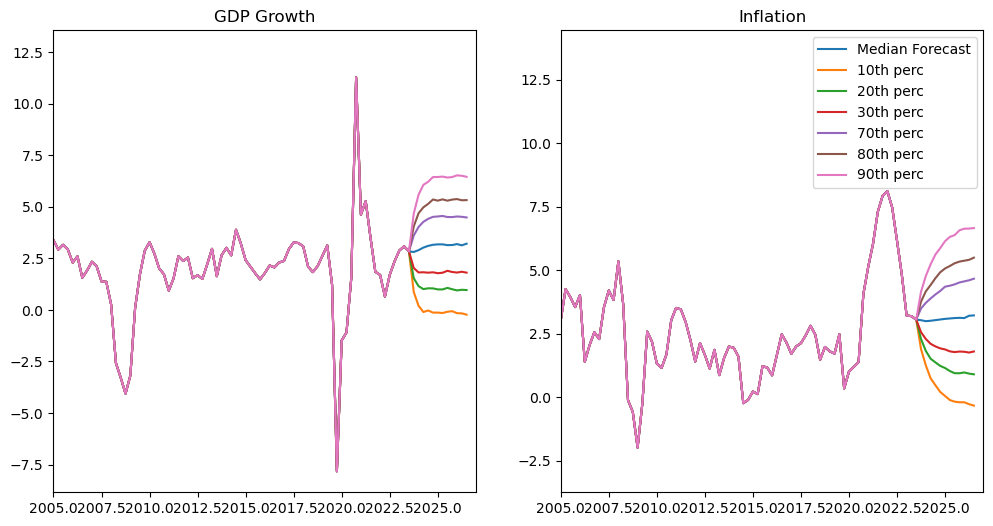

In [35]:
fig = plt.figure(figsize=(12, 6))

# TT = np.arange(1948.75, 2014.25, 0.25)
TT = np.arange(1948.00, 2026.75, 0.25)


plt.subplot(1, 2, 1)
percentiles = np.percentile(out1, [50, 10, 20, 30, 70, 80, 90], axis=1)
plt.plot(TT, percentiles.T)
plt.xlim([2005, 2027])
plt.title('GDP Growth')

plt.subplot(1, 2, 2)
percentiles = np.percentile(out2, [50, 10, 20, 30, 70, 80, 90], axis=1)
plt.plot(TT, percentiles.T)
plt.xlim([2005, 2027])
plt.legend(['Median Forecast', '10th perc', '20th perc', '30th perc',
            '70th perc', '80th perc', '90th perc'])
plt.title('Inflation')

plt.show()

fig.savefig('forecast_gdp_and_inflation.png', dpi=fig.dpi)

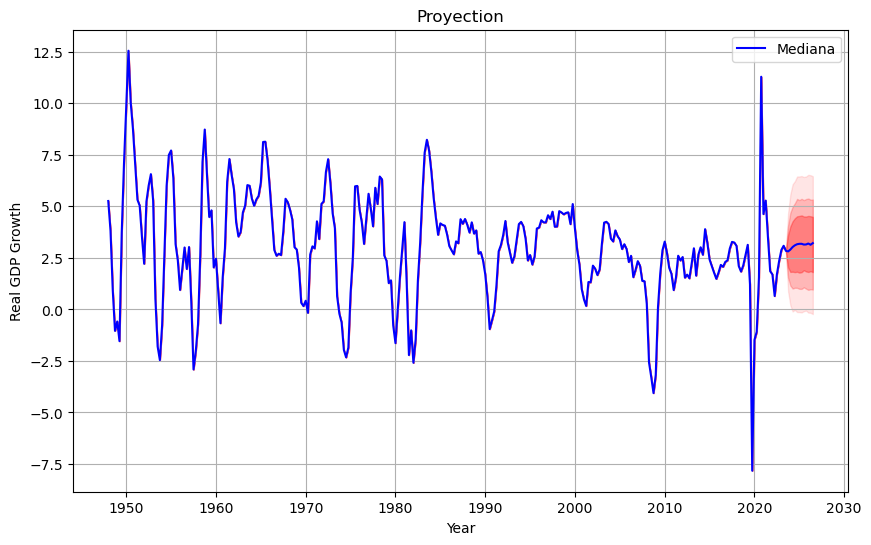

In [66]:
percentiles = np.percentile(out1.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

for i, alpha in enumerate([0.1, 0.2, 0.3]):
    ax.fill_between(TT, percentiles[i], percentiles[6-i], color='red', alpha=alpha)

ax.plot(TT, percentiles[3], color='blue', label='Mediana')

# ax.set_xlim([2010, 2026.75])
ax.set_title('Proyection')
ax.set_xlabel('Year')
ax.set_ylabel('Real GDP Growth')
ax.legend()
ax.grid(True)

plt.show()

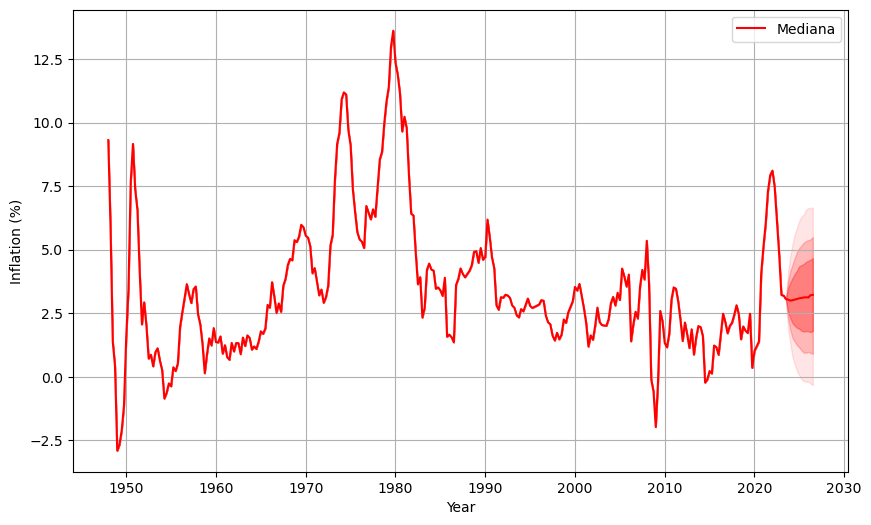

In [67]:
percentiles = np.percentile(out2.T, [10, 20, 30, 50, 70, 80, 90], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

# bandas de confianza como mapas de calor
for i, alpha in enumerate([0.1, 0.2, 0.3]):
    ax.fill_between(TT, percentiles[i], percentiles[6-i], color='red', alpha=alpha)

ax.plot(TT, percentiles[3], color='red', label='Mediana')

# ax.set_xlim([2010, 2026.75])
# ax.set_title('Proyection')
ax.set_xlabel('Year')
ax.set_ylabel('Inflation (%)')
ax.legend()
ax.grid(True)

plt.show()